# Source Detection

This notebook shows an end to end radio interferometry pipeline from the sky to final image using the Karabo pipeline. In addition, we show you how to get the pixel coordinates of the point sources of the produced image. The simulation of the sky, telescope and observation are based on [OSKAR](https://ska-telescope.gitlab.io/sim/oskar/), the imaging on [RASCIL](https://ska-telescope.gitlab.io/external/rascil/index.html).

For this example we use the GLEAM survey [GLEAM EGC catalog version 2](https://vizier.cds.unistra.fr/viz-bin/VizieR-3), which can be downloaded from the [VizieR](https://cdsarc.unistra.fr/viz-bin/cat/VIII/100) service. To download the full survey, you have to change **preferences/max** to unlimited. The download here was done using the **FITS (binary) Table** option which can be selected in the dropdown menu below. The GLEAM survey was created using the Murchison Widefield Array (MWA), the low-frequency Square Kilometre Array (SKA1 LOW) precursor located in western Australia. The catalogue covers 24,402 square degrees, over declinations south of +30° and galactic latitudes outside 10° of the galactic plane, excluding some areas such as the Magellanic clouds. It contains 307,456 radio sources with 20 separate flux density measurements across 72-231 MHz, selected from a time- and frequency- integrated image centred at 200 MHz, with a resolution of ~=2'.

In [1]:
import sys
from datetime import timedelta, datetime
import oskar
import matplotlib
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import numpy as np

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy import wcs

from karabo.simulation.sky_model import *
from karabo.simulation.observation import *
from karabo.simulation.utils import *
from karabo.simulation.telescope import *
from karabo.simulation.observation import *
from karabo.simulation.interferometer import *
from karabo.util.jupyter import setup_jupyter_env

## Sky Catalog

Of course, any catalog downloaded in any format such as .fits or .csv can be used. Since the structures of the catalogs can differ significantly, we leave the preprocessing to the format of the `SkyModel` (from `karabo.simulation.sky_model`) to the user. The `SkyModel` has the following catalog format:

- right_ascension:
- declination:
- stokes_I_flux:
- stokes_Q_flux:
- stokes_U_flux:
- stokes_V_flux:
- reference_frequency:
- spectral_index:
- rotation_measure:
- major_axis_FWHM:
- minor_axis_FWHM:
- position_angle:
- source_id:

For this example we only use right ascension (RAJ2000) and declination (DEJ2000) and the Stokes I peak flux intensity at 76 MHz (Fp076). There are some sources which have no flux values in the corresponding frequency band. These must be removed first.

In [2]:
gleam = SkyModel.get_fits_catalog('./GLEAM_EGC.fits')
df_gleam = gleam.to_pandas()
df_gleam.head()

,GLEAM,RAJ2000,DEJ2000,Fpwide,Fintwide,awide,bwide,pawide,Fp076,Fint076,...,a220,b220,pa220,Fp227,Fint227,a227,b227,pa227,alpha,Fintfit200
0,b'J235139-894114',357.914368,-89.687309,0.262282,0.248581,219.263,146.4811,-4.158033,0.531743,0.528997,...,171.534,127.1215,-4.158033,0.097147,0.090779,170.630,123.0671,-4.158033,-0.370882,0.271901
1,b'J223320-891247',338.336243,-89.213310,0.160685,0.150291,217.707,145.0885,8.403455,-0.032964,-0.032702,...,169.540,125.5117,8.403455,0.084467,0.076873,168.625,121.4038,8.403455,NaN,NaN
2,b'J231335-890921',348.399048,-89.155968,0.311750,0.320281,234.137,148.1622,-1.929386,0.459728,0.463359,...,190.178,129.0525,-1.929386,0.219189,0.230755,189.363,125.0609,-1.929386,-0.751062,0.321428
3,b'J230111-884502',345.296844,-88.750610,1.540468,1.589200,203.822,170.7923,-2.558145,2.683800,2.686571,...,154.506,151.2983,87.441856,1.146250,1.157487,151.188,150.2724,87.441856,-0.453153,1.496247
4,b'J211508-884427',318.784729,-88.740990,0.137430,0.192555,282.809,167.1542,26.895504,0.368415,0.393777,...,247.645,150.4759,26.895504,0.015579,0.025159,247.020,147.0669,26.895504,-0.239030,0.199019


Now we create the `sky_array` with the help of the catalog. This can either be included in the constructor of the `SkyModel`. Additional sources can be added using `add_point_sources` or `add_point_source`. The values of the sources can be modified using the square brackets `add_point_sources` like an `np.ndarray`. In the next chunk we initialize the sources and pass them to the constructor. Since the source ID's are on the far right and we would otherwise have to fill everything with null vectors (null vectors are the default values for undefined columns), we do this afterwards with `sky[:,-1] = df_gleam['GLEAM']`.

In [3]:
ref_freq = 76e6
df_gleam = df_gleam[~df_gleam['Fp076'].isna()]
ra, dec, fp = df_gleam['RAJ2000'], df_gleam['DEJ2000'], df_gleam['Fp076']
sky_array = np.column_stack((ra, dec, fp, np.zeros(ra.shape[0]), np.zeros(ra.shape[0]), 
                             np.zeros(ra.shape[0]), [ref_freq]*ra.shape[0])).astype('float32')
sky = SkyModel(sky_array)
sky[:,-1] = df_gleam['GLEAM']
sky.num_sources

307087

Before further steps are taken, the phase center of the telescope must be defined.

In [4]:
phase_center = [250,-80] # ra,dec

Now we just look at the Log10 Stokes I flux of the GLEAM survey. This provides a better overview of how the survey looks like on the sphere.

<ipython-input-5-18bbb5155222>:7: RuntimeWarning: invalid value encountered in log10
  log_flux = np.log10(flux)


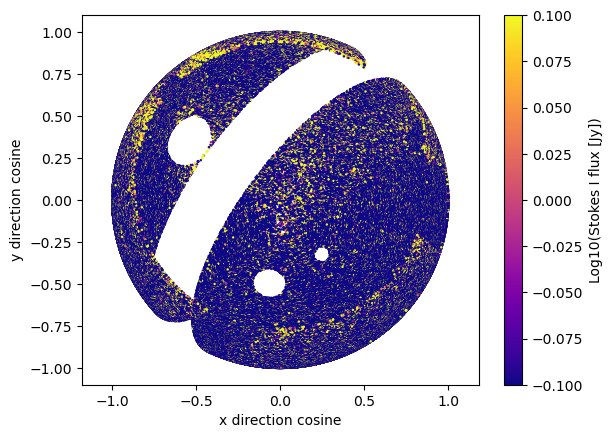

In [5]:
def plot_sky(sky, phase_center):
    ra0, dec0 = phase_center[0], phase_center[1]
    data = sky[:,0:3]
    ra = np.radians(data[:, 0] - ra0)
    dec = np.radians(data[:, 1])
    flux = data[:, 2]
    log_flux = np.log10(flux)
    x = np.cos(dec) * np.sin(ra)
    y = np.cos(np.radians(dec0)) * np.sin(dec) - \
                np.sin(np.radians(dec0)) * np.cos(dec) * np.cos(ra)
    sc = plt.scatter(x, y, s=.5, c=log_flux, cmap='plasma',
                vmin=np.min(log_flux), vmax=np.max(log_flux))
    plt.axis('equal')
    plt.xlabel('x direction cosine')
    plt.ylabel('y direction cosine')
    plt.colorbar(sc, label='Log10(Stokes I flux [Jy])')
    plt.show()
    
plot_sky(sky, phase_center)

Now that we have determined the phase center we can take a closer look at how the point sources are distributed around the center. For this we use a coordinate 2d image projection with the phase center as the origin using the the world coordinate system ([wcs](https://docs.astropy.org/en/stable/wcs/index.html)) of astropy. Specific information about the wcs parameters can be found [here](https://docs.astropy.org/en/stable/api/astropy.wcs.Wcsprm.html). For this illustration, we take the Stokes I flux intensity into account to address for it's brightness. The value conversion is done using a function which is defined in the argument `cfun` of `explore_sky`. Here we uses np.log10 as default. If you wish to not have the intensity colored just set `cfun=None`.

Important here is that `explore_sky` sets up a default `wcs` if none is set. So if you want to have a specific `wcs` for the `SkyModel` you have to set it prior or afterwards yourself.

/home/lukas/i4ds/ska/KaraboPipeline/karabo/simulation/sky_model.py:257: RuntimeWarning: invalid value encountered in log10
  flux = cfun(flux)


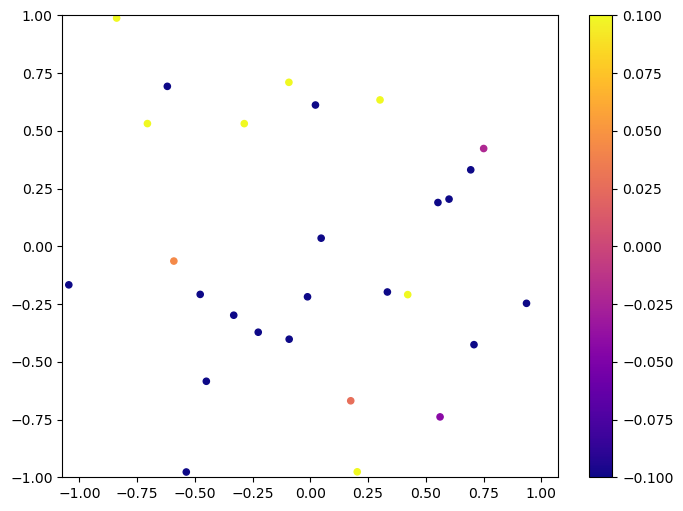

In [6]:
sky.explore_sky(phase_center=phase_center, figsize=(8,6))

Now, to have only a partition of the sky, we can use the `filter_by_radius`, which filters from the phase center with an inner and outer radius in degrees. We provide an additional filter `filter_by_flux` which filters the sky using the Stokes I flux and `filter_by_frequency` which filters the sky using the reference frequency. In addition, we set the world coordinate system `astropy.wcs` using `setup_default_wcs` at the `phase_center`. The wcs is later needed for coordinate transformation when the imaging parameters are known.

In [7]:
# first filter sky by inner and outer radius in degrees from the phase center
sky.filter_by_radius(0, .55, phase_center[0], phase_center[1])
sky.setup_default_wcs(phase_center, set_as_instance=True)
sky.num_sources

8

Now let's look at the filtered sources.

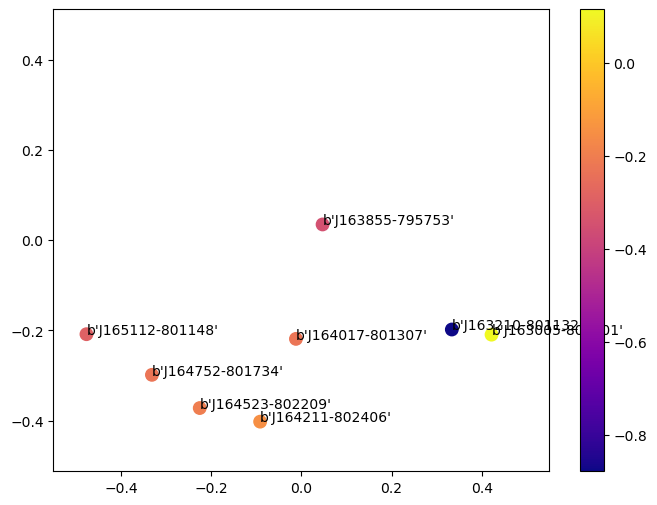

In [8]:
sky.explore_sky(phase_center=phase_center, figsize=(8,6), s=80,
                xlim=(-.55,.55), ylim=(-.55,.55), with_labels=True)

### Telescope & Observation Module

Now that we have filtered the sky and set the phase center, we define and simulate the telescope and the observation. With `get_OSKAR_Example_Telescope` we get a `Telescope` object (from `karabo.simulation.telescope`) consisting of an interferometer with 30 aperture array stations, each with 2587 antenna elements.

In [ ]:
telescope = get_OSKAR_Example_Telescope()

Then we define an `observation` (from `karabo.simulation.observation`) where the observation parameters are defined.

In [ ]:
observation = Observation(start_frequency_hz=ref_freq, start_date_and_time=datetime(2000, 1, 1, 12, 0),
                          length=timedelta(hours=12), number_of_channels=16, frequency_increment_hz=20e6,
                          phase_centre_ra_deg=phase_center[0], phase_centre_dec_deg=phase_center[1],
                          number_of_time_steps=24)

Now we set simulation parameters using `InterferometerSimulation` (from `karabo.simulation.intererometer`) in the constructor and start the simulation using `run_simulation`.

In [ ]:
interferometer = InterferometerSimulation(ms_path='./visibilities_gleam.ms', channel_bandwidth_hz=1e6,
                                          time_average_sec=10)

In [ ]:
interferometer.run_simulation(telescope, sky, observation)

The visibilities are now stored in the casa measurement set 'visibilities_gleam.ms' and can be used for imaging.

### Imaging

Now we start the imaging process using the `Imager` (from `karabo.simulation.imager`) with the visibilities 'visibilities_gleam.ms'. The `Imager` allows various configurations concerning imaging, calibration, Clean and Dask. Important for source detection is `imaging_npixel` which defines the number of pixels in x,y rsp. ra,dec direction and `imaging_cellsize` which defines the coverage of a pixel in radian. In this example the image covers $3.878509448876288\times 10^{-5} * 2048 * 180 / \pi \approx 4.55°$ degrees, so $4.55/2 = 2.28°$ degrees in each direction from the phase center.

In [ ]:
from karabo.simulation.imager import *

imager = Imager(ingest_msname='./visibilities_gleam.ms',
                ingest_dd=[0],
                ingest_vis_nchan=16,
                ingest_chan_per_blockvis=1,
                ingest_average_blockvis=True,
                imaging_npixel=2048,
                imaging_cellsize=3.878509448876288e-05,
                imaging_weighting='robust',
                imaging_robustness=-.5,
                clean_nmajor=2,
                clean_algorithm='mmclean',
                clean_scales=[0,6,10,30,60],
                clean_fractional_threshold=.3,
                clean_threshold=.12e-3,
                clean_nmoment=5,
                clean_psf_support=640,
                clean_restored_output='integrated')

imager.imaging_rascil()

## Pixel Coordinates

Now we want to have the pixel coordinates on the created image. We achieve this with the `get_pixel_coord` function of the `Imager` object. For this we can use directly the object used for imaging or a new one. Creating a new/different `Imager` object is useful if you haven't executed the imaging process itself or the imaging was done using another tool.

So we get the pixel coordinates `px` and `py` as well as the indices of the objects of the `SkyModel`. Thus we can infer the pixel coordinates directly to the sources. Below the image coordinates are shown proportional to the image size.

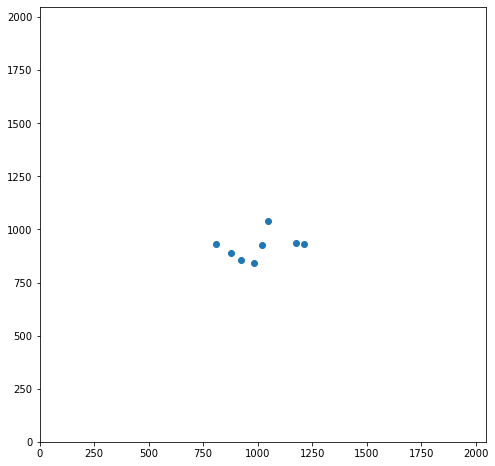

In [9]:
from karabo.simulation.imager import Imager
import matplotlib
matplotlib.use('tkagg')
%matplotlib inline

imager2 = Imager(imaging_npixel=2048,
                 imaging_cellsize=3.878509448876288e-05)

px, py, sky_idxs = imager2.get_pixel_coord(sky=sky, filter_outlier=True)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(px, py)
plt.xlim((0,2048))
plt.ylim((0,2048))

for i, txt in enumerate(sky[sky_idxs,-1]):
    #ax.annotate(txt, (px[i], py[i]))
    pass
plt.show()

In [10]:
pd.DataFrame({'sources':sky[sky_idxs,-1],'px':px,'py':py})

,sources,px,py
0,b'J164211-802406',983.754166,843.993938
1,b'J164523-802209',923.476253,857.575398
2,b'J164752-801734',875.761466,890.715306
3,b'J163005-801201',1214.682496,930.813835
4,b'J164017-801307',1019.482292,926.596812
5,b'J163210-801132',1175.053128,935.950129
6,b'J165112-801148',810.424743,931.271274
7,b'J163855-795753',1046.059539,1040.788873
